In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/76144e5b-6e52-493f-825e-e2c551914a21.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/786da551-fa70-403d-8ae5-34276b2ec264.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/7677a42b-ca7d-4a44-982e-b6dda0f67931.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/a2cc7369-7acf-4652-a93b-2ef4c51f386c.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/294abc10-ddf2-491d-a335-ec9b0bb78bc5.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/100H0004.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/3c4a04c8-61d4-462c-9d2f-81853ed76f59.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_center_wise/Simula/NBI/images/e6f210df-bd52-476d-a93c-e626fc44571c.jpg
/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_c

In [2]:
import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import imageio
from torchvision import models  
from tqdm import tqdm
from torchvision.models import vit_b_16

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def augment_data(images, masks, save_path, augment=True):
    size = (224, 224)  
    # resize all images and masks to this size

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name from the image path """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)  # read image
        y = imageio.mimread(y)[0]  # read mask

        if augment:
            # apply augmentations

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            # list of original and augmented images and masks
            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]
        else:
            # save the original image and mask
            X = [x]
            Y = [y]

        # save images and masks
        index = 0
        for i, m in zip(X, Y):
            # resize images and masks
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            # filenames for the augmented data
            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            # to save images and masks
            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)


            # save images and masks to the directory
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1


In [4]:
if __name__ == "__main__":
    """ Seeding for reproducibility """
    np.random.seed(42)

    """ Directories for images and masks """
    image_dir = "/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_modality_wise/WLI/images"
    mask_dir = "/kaggle/input/multi-center-polypbd/PolypDB/PolypDB_modality_wise/WLI/masks"
    save_path_train = "/kaggle/working/augmented_data/train"
    save_path_test = "/kaggle/working/augmented_data/test"

    os.makedirs(os.path.join(save_path_train, "image"), exist_ok=True)
    os.makedirs(os.path.join(save_path_train, "mask"), exist_ok=True)
    os.makedirs(os.path.join(save_path_test, "image"), exist_ok=True)
    os.makedirs(os.path.join(save_path_test, "mask"), exist_ok=True)
   

In [5]:
image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg') or img.endswith('.png')])
mask_paths = sorted([os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir) if mask.endswith('.jpg') or mask.endswith('.png')])

In [6]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)

In [7]:
augment_data(train_x, train_y, save_path_train, augment=True)
augment_data(test_x, test_y, save_path_test, augment=False)

100%|██████████| 1077/1077 [00:32<00:00, 33.62it/s]


In [8]:
class PolypDB(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        
    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image / 255.0 
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        
        """ Reading masks """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask / 255.0 
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        
        return image, mask
    
    def __len__(self):
        return self.n_samples

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vit_b_16

# Example Encoder Block
class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        skip = self.conv(x)
        pooled = self.pool(skip)
        return skip, pooled
    
      # Example Decoder Block
class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, inputs, skip):
        x = self.up(inputs)
        # Resize x to match the size of skip for concatenation 
        x = F.interpolate(x, size=skip.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

# Main UNet Model with ViT
class build_unet_with_vit(nn.Module):
    def __init__(self):
        super(build_unet_with_vit, self).__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Conv layer to reduce channels from 512 to 3 for ViT """
        self.channel_reduction = nn.Conv2d(512, 3, kernel_size=1)

        """ Vision Transformer as Bottleneck """
        self.vit_block = vit_b_16(pretrained=False)  # Load pre-trained ViT model

        """ Fully Connected Layer to reshape ViT output """
        self.fc = nn.Linear(1000, 1024 * 7 * 7)  # Project ViT output to required shape

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Resize before Vision Transformer Bottleneck """
        p4_resized = F.interpolate(p4, size=(224, 224), mode='bilinear', align_corners=False)

        """ Reduce channels from 512 to 3 for ViT input """
        p4_reduced = self.channel_reduction(p4_resized)
        """ Vision Transformer Block """
        vit_output = self.vit_block(p4_reduced)  # Output tensor of shape [batch_size, 1000]

        """ Project and Reshape ViT output """
        vit_output_projected = self.fc(vit_output)  # Shape: [batch_size, 1024 * 7 * 7]
        vit_output_reshaped = vit_output_projected.view(vit_output.size(0), 1024, 7, 7)  # Shape: [batch_size, 1024, 7, 7]

        """ Decoder """
        d1 = self.d1(vit_output_reshaped, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [10]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Apply sigmoid activation
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Dice + Binary Cross-Entropy Loss
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        dice_bce = bce + dice_loss

        return dice_bce   

In [11]:
train_dataset = PolypDB(
        images_path=sorted([os.path.join(save_path_train, "image", img) for img in os.listdir(os.path.join(save_path_train, "image"))]),
        masks_path=sorted([os.path.join(save_path_train, "mask", mask) for mask in os.listdir(os.path.join(save_path_train, "mask"))])
    )
test_dataset = PolypDB(
        images_path=sorted([os.path.join(save_path_test, "image", img) for img in os.listdir(os.path.join(save_path_test, "image"))]),
        masks_path=sorted([os.path.join(save_path_test, "mask", mask) for mask in os.listdir(os.path.join(save_path_test, "mask"))])
    )

In [12]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:

model = build_unet_with_vit().to(device)

vit_weights = torch.load("/kaggle/input/visiontransformer/pytorch/default/1/vit_b_16-c867db91.pth")
model.vit_block.load_state_dict(vit_weights)

model.train()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-14-bb24c4248563>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

build_unet_with_vit(
  (e1): encoder_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplac

In [15]:
model = build_unet_with_vit().to(device)  
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = DiceBCELoss()
loss_fn = DiceBCELoss()

In [16]:
def iou_score(preds, targets, smooth=1):
    preds = (preds > 0.5).float()  # Apply a threshold to get binary predictions
    targets = targets.float()
    
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    
    return (intersection + smooth) / (union + smooth)

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time // 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [18]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    model.train()
    
    for x, y in tqdm(loader, desc='Training'):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    return epoch_loss
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    total_iou = 0.0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Evaluating'):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
            
            total_iou += iou_score(y_pred, y)

    epoch_loss /= len(loader)
    average_iou = total_iou / len(loader)
    return epoch_loss, average_iou
# Training Loop
# Initialize best IoU score
best_iou = 0.0

# Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()

    # Training and validation
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss, valid_iou = evaluate(model, test_loader, loss_fn, device)

    # Update the best IoU if current IoU is higher
    if valid_iou > best_iou:
        best_iou = valid_iou

    # Logging the epoch results
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f}')
    print(f'\tVal. IoU: {valid_iou:.3f} | Best IoU: {best_iou:.3f}')

Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.61it/s]


Epoch: 01 | Time: 14m 47s
	Train Loss: 0.827
	Val. Loss: 0.718
	Val. IoU: 0.427 | Best IoU: 0.427


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 44.17it/s]


Epoch: 02 | Time: 14m 46s
	Train Loss: 0.524
	Val. Loss: 0.579
	Val. IoU: 0.530 | Best IoU: 0.530


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 44.15it/s]


Epoch: 03 | Time: 14m 46s
	Train Loss: 0.415
	Val. Loss: 0.511
	Val. IoU: 0.595 | Best IoU: 0.595


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.80it/s]


Epoch: 04 | Time: 14m 48s
	Train Loss: 0.360
	Val. Loss: 0.490
	Val. IoU: 0.602 | Best IoU: 0.602


Evaluating: 100%|██████████| 1077/1077 [00:25<00:00, 42.76it/s]


Epoch: 05 | Time: 14m 54s
	Train Loss: 0.325
	Val. Loss: 0.452
	Val. IoU: 0.630 | Best IoU: 0.630


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.71it/s]


Epoch: 06 | Time: 14m 52s
	Train Loss: 0.355
	Val. Loss: 0.449
	Val. IoU: 0.639 | Best IoU: 0.639


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.38it/s]


Epoch: 07 | Time: 14m 52s
	Train Loss: 0.295
	Val. Loss: 0.416
	Val. IoU: 0.662 | Best IoU: 0.662


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.12it/s]


Epoch: 08 | Time: 14m 52s
	Train Loss: 0.341
	Val. Loss: 0.460
	Val. IoU: 0.622 | Best IoU: 0.662


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.39it/s]


Epoch: 09 | Time: 14m 52s
	Train Loss: 0.278
	Val. Loss: 0.402
	Val. IoU: 0.665 | Best IoU: 0.665


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.62it/s]


Epoch: 10 | Time: 14m 51s
	Train Loss: 0.364
	Val. Loss: 0.627
	Val. IoU: 0.509 | Best IoU: 0.665


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.28it/s]


Epoch: 11 | Time: 14m 50s
	Train Loss: 0.344
	Val. Loss: 0.470
	Val. IoU: 0.614 | Best IoU: 0.665


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.47it/s]


Epoch: 12 | Time: 14m 51s
	Train Loss: 0.295
	Val. Loss: 0.427
	Val. IoU: 0.648 | Best IoU: 0.665


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.52it/s]


Epoch: 13 | Time: 14m 51s
	Train Loss: 0.286
	Val. Loss: 0.409
	Val. IoU: 0.669 | Best IoU: 0.669


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.47it/s]


Epoch: 14 | Time: 14m 51s
	Train Loss: 0.246
	Val. Loss: 0.432
	Val. IoU: 0.637 | Best IoU: 0.669


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.63it/s]


Epoch: 15 | Time: 14m 50s
	Train Loss: 0.239
	Val. Loss: 0.524
	Val. IoU: 0.594 | Best IoU: 0.669


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.45it/s]


Epoch: 16 | Time: 14m 51s
	Train Loss: 0.222
	Val. Loss: 0.366
	Val. IoU: 0.698 | Best IoU: 0.698


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.53it/s]


Epoch: 17 | Time: 14m 51s
	Train Loss: 0.207
	Val. Loss: 0.336
	Val. IoU: 0.713 | Best IoU: 0.713


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.67it/s]


Epoch: 18 | Time: 14m 51s
	Train Loss: 0.192
	Val. Loss: 0.324
	Val. IoU: 0.725 | Best IoU: 0.725


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.59it/s]


Epoch: 19 | Time: 14m 50s
	Train Loss: 0.182
	Val. Loss: 0.375
	Val. IoU: 0.685 | Best IoU: 0.725


Evaluating: 100%|██████████| 1077/1077 [00:24<00:00, 43.31it/s]

Epoch: 20 | Time: 14m 51s
	Train Loss: 0.174
	Val. Loss: 0.336
	Val. IoU: 0.738 | Best IoU: 0.738


In [19]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for j in range(images.size(0)):
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(images[j].permute(1, 2, 0).cpu())
                axs[0].set_title("Input Image")
                axs[1].imshow(masks[j].squeeze().cpu(), cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[2].imshow(preds[j].squeeze().cpu(), cmap='gray')
                axs[2].set_title("Predicted Mask")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()


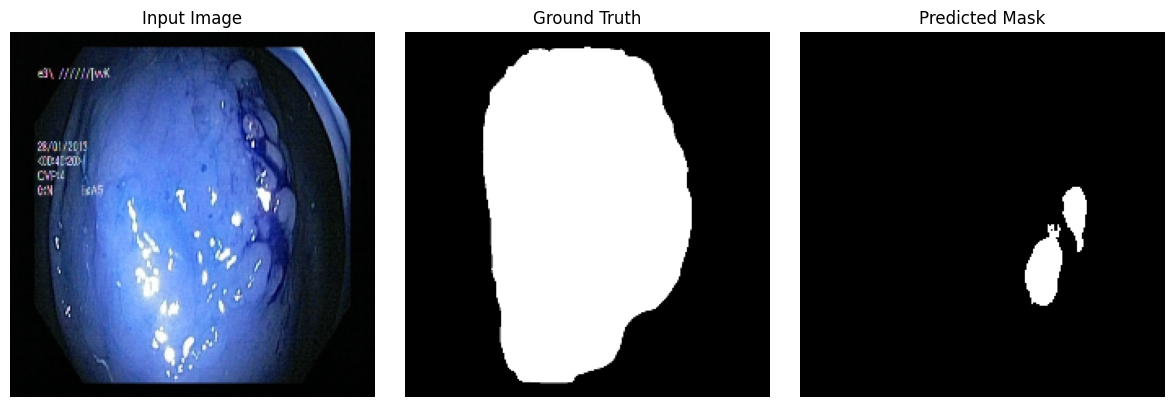

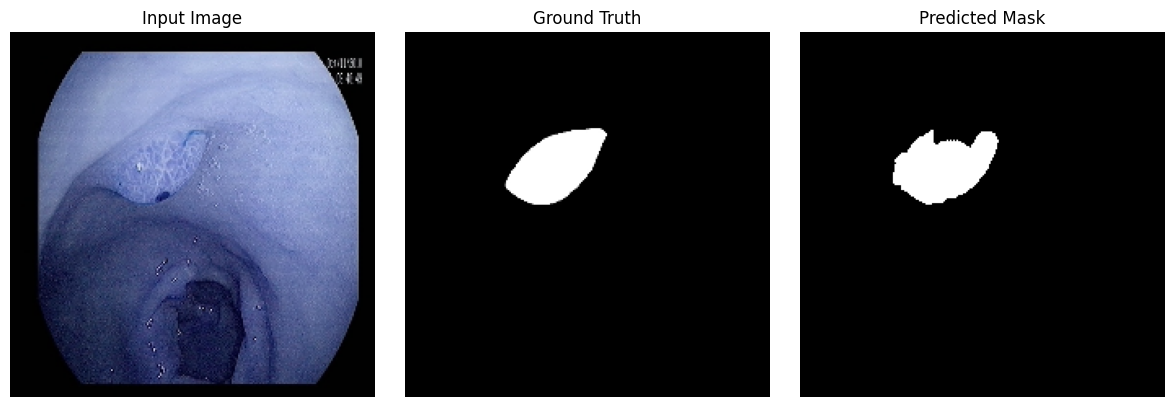

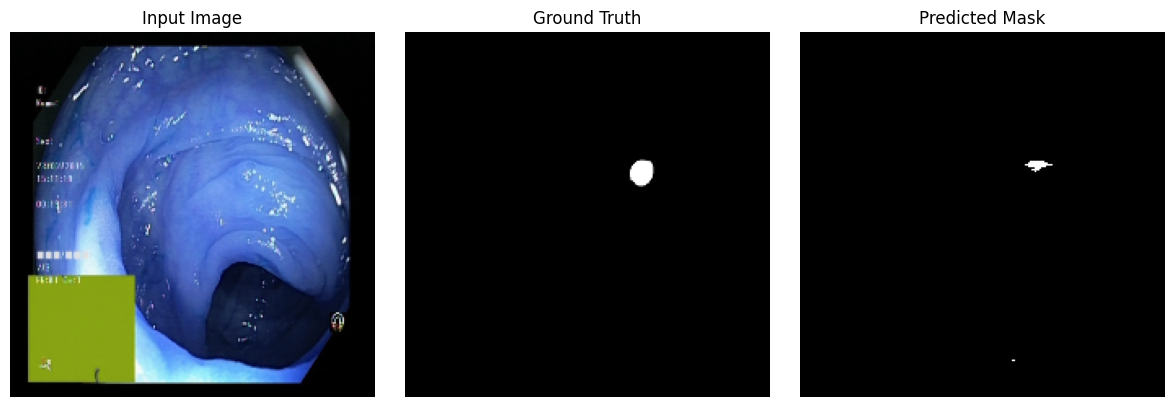

In [24]:
show_predictions(model, test_loader, num_samples=3)

